In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('ticks')
sns.set_context('notebook')

In [2]:
import curveball

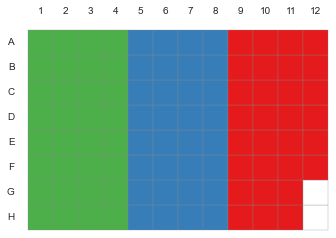

In [3]:
plate = pd.read_csv(r"D:/workspace/curveball_project/python/plate_templates/G-RG-R.csv")
fig,ax = curveball.plots.plot_plate(plate)

['G' 'RG' 'R' '0']


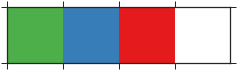

In [4]:
sns.palplot(plate.Color.unique())
print plate.Strain.unique()

In [5]:
filename = "D:/Google Drive/ex silico/tecan/Yoav_08022015_nolag.xlsx"
df = curveball.ioutils.read_tecan_xlsx(filename, ('OD','Green','Red'), max_time=14, plate=plate)

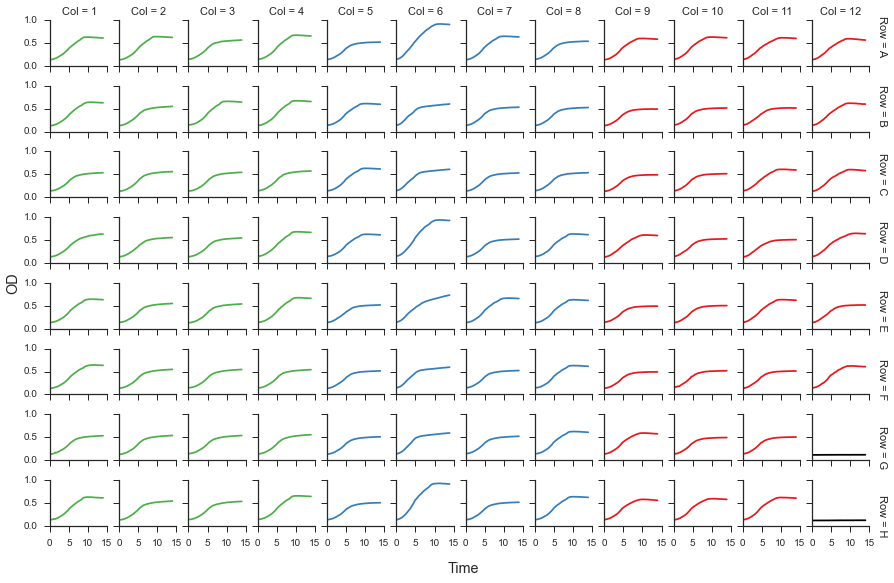

In [6]:
g = curveball.plots.plot_wells(df, 'Time', 'OD')

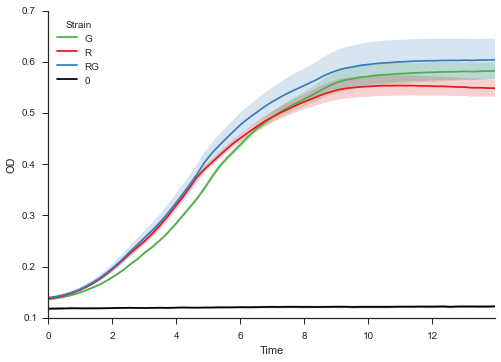

In [7]:
g = curveball.plots.tsplot(df)

[[Model]]
    Model(richards_function)
[[Fit Statistics]]
    # function evals   = 131
    # data points      = 61
    # variables        = 4
    chi-square         = 6.849
    reduced chi-square = 0.120
[[Variables]]
    y0:   0.13134016 +/- 0.000981 (0.75%) (init= 0.1393781)
    r:    0.22009256 +/- 0.005165 (2.35%) (init= 0.07495804)
    K:    0.59420035 +/- 0.008732 (1.47%) (init= 0.604425)
    nu:   5.82807405 +/- 1.405285 (24.11%) (init= 1)



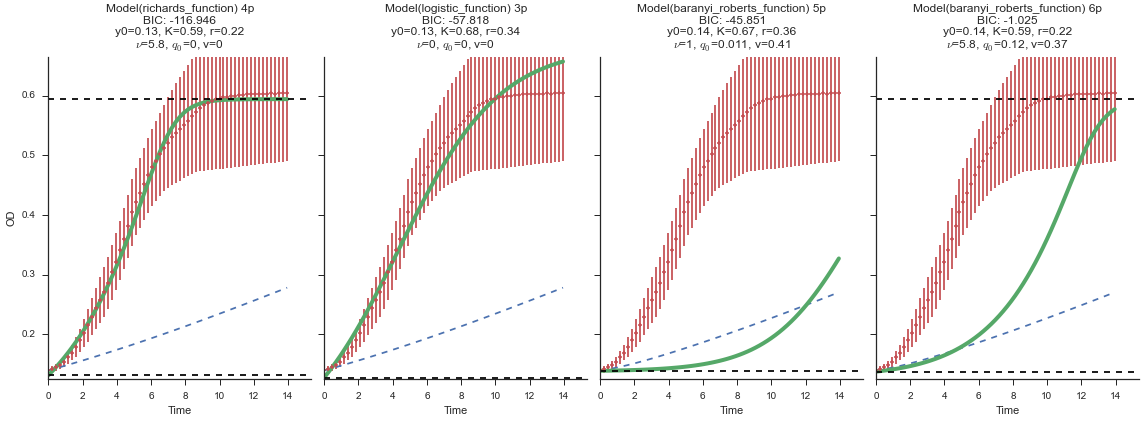

In [8]:
df_RG = df[df.Strain == 'RG']
models_RG,fig,ax = curveball.models.fit_model(df_RG)

# Cook's distance

In [16]:
import copy
def cook_distance(df, model_fit):
    p = model_fit.nvarys
    MSE = model_fit.chisqr / model_fit.ndata
    p, MSE
    wells = df_RG.Well.unique().tolist()
    D = {}
    
    for well in wells:    
        _df = df[df.Well != well]
        _df = _df.groupby('Time')['OD'].agg([np.mean, np.std]).reset_index()
        assert np.isfinite(1./_df['std']).all()
        model_fit_i = copy.deepcopy(model_fit)
        model_fit_i.fit(_df['mean'], weights=1./_df['std'])
        D[well] = model_fit_i.chisqr / (p * MSE)
    return D

In [11]:
def plot_cook_dist(D):
    fig,ax = plt.subplots(1,1)
    D = sorted(D.items())
    wells = [x[0] for x in D]
    distances = [x[1] for x in D]
    ax.stem(distances)
    dist_mean, dist_std = np.mean(distances), np.std(distances)
    ax.axhline(y=dist_mean, ls='-', color='k')
    ax.axhline(y=dist_mean + 2 * dist_std, ls='--', color='k')
    ax.axhline(y=dist_mean - 2 * dist_std, ls='--', color='k')
    ax.set_xticks(range(len(wells)))
    ax.set_xticklabels(wells, rotation=90)
    ax.set_xlabel('Well')
    ax.set_ylabel("Cook's distance")
    sns.despine()

    outliers = [well for well,dist in D if dist > (dist_mean + 2 * dist_std)]
    return outliers,fig,ax

[u'D6', u'F6']


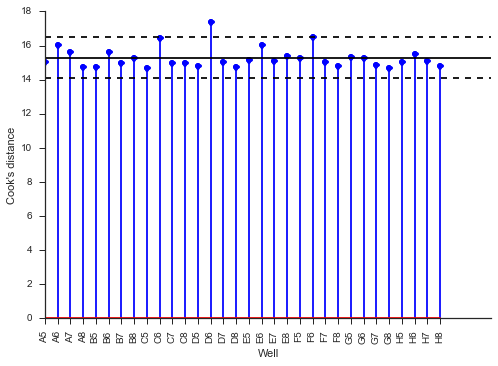

In [20]:
_df = df_RG.copy()
model_fit = curveball.models.fit_model(_df, PLOT=False, PRINT=False)[0]
D = cook_distance(_df, model_fit)
outliers,fig,ax = plot_cook_dist(D)
print outliers

[u'A6', u'C6', u'E6']


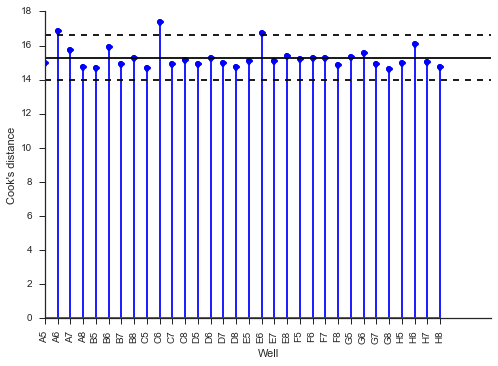

In [21]:
_df = _df[~_df.Well.isin(outliers)]
agg_df = _df.groupby('Time')['OD'].agg([np.mean, np.std]).reset_index()
assert np.isfinite(1./agg_df['std']).all()
model_fit.fit(agg_df['mean'], weights=1./agg_df['std'])
D = cook_distance(_df, model_fit)
outliers,fig,ax = plot_cook_dist(D)
print outliers

[u'B6', u'H6']


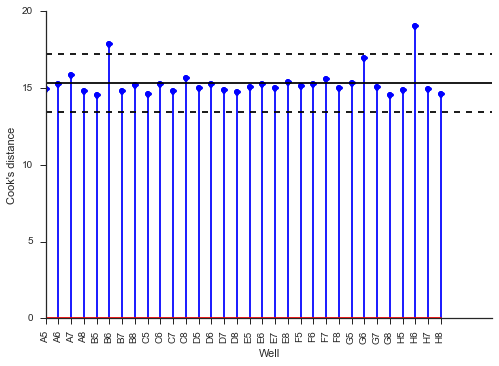

In [22]:
_df = _df[~_df.Well.isin(outliers)]
agg_df = _df.groupby('Time')['OD'].agg([np.mean, np.std]).reset_index()
assert np.isfinite(1./agg_df['std']).all()
model_fit.fit(agg_df['mean'], weights=1./agg_df['std'])
D = cook_distance(_df, model_fit)
outliers,fig,ax = plot_cook_dist(D)
print outliers

[u'G6']


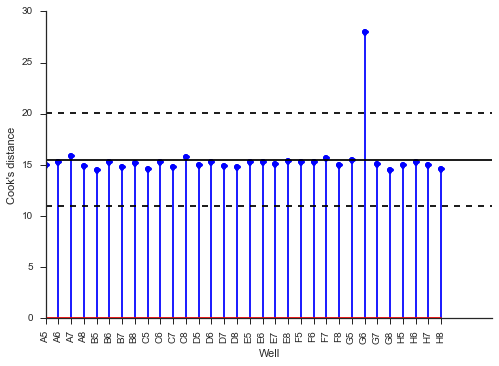

In [23]:
_df = _df[~_df.Well.isin(outliers)]
agg_df = _df.groupby('Time')['OD'].agg([np.mean, np.std]).reset_index()
assert np.isfinite(1./agg_df['std']).all()
model_fit.fit(agg_df['mean'], weights=1./agg_df['std'])
D = cook_distance(_df, model_fit)
outliers,fig,ax = plot_cook_dist(D)
print outliers

[u'A7', u'C8']


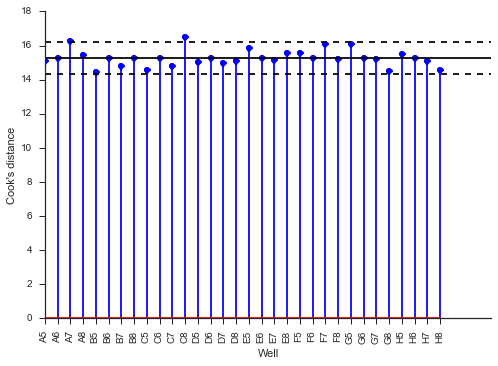

In [24]:
_df = _df[~_df.Well.isin(outliers)]
agg_df = _df.groupby('Time')['OD'].agg([np.mean, np.std]).reset_index()
assert np.isfinite(1./agg_df['std']).all()
model_fit.fit(agg_df['mean'], weights=1./agg_df['std'])
D = cook_distance(_df, model_fit)
outliers,fig,ax = plot_cook_dist(D)
print outliers

[u'F7', u'G5']


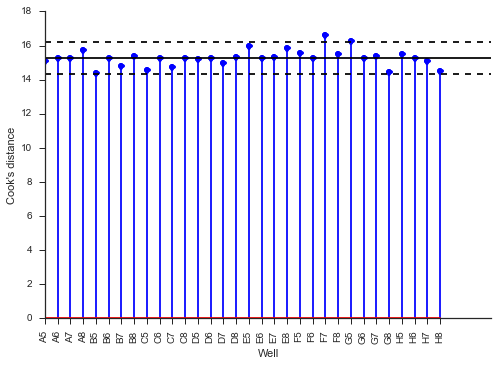

In [25]:
_df = _df[~_df.Well.isin(outliers)]
agg_df = _df.groupby('Time')['OD'].agg([np.mean, np.std]).reset_index()
assert np.isfinite(1./agg_df['std']).all()
model_fit.fit(agg_df['mean'], weights=1./agg_df['std'])
D = cook_distance(_df, model_fit)
outliers,fig,ax = plot_cook_dist(D)
print outliers

[u'E8']


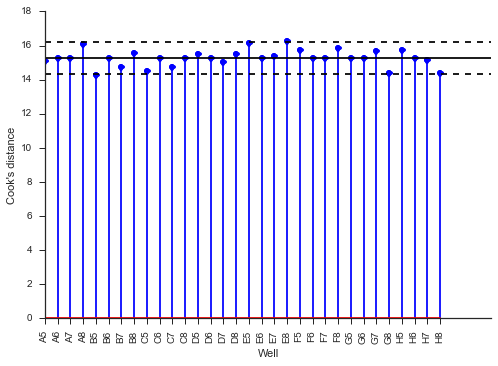

In [26]:
_df = _df[~_df.Well.isin(outliers)]
agg_df = _df.groupby('Time')['OD'].agg([np.mean, np.std]).reset_index()
assert np.isfinite(1./agg_df['std']).all()
model_fit.fit(agg_df['mean'], weights=1./agg_df['std'])
D = cook_distance(_df, model_fit)
outliers,fig,ax = plot_cook_dist(D)
print outliers

[]


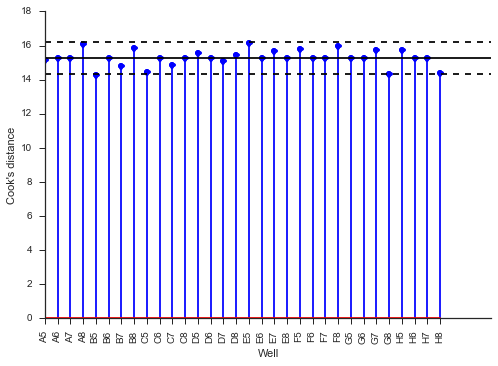

In [27]:
_df = _df[~_df.Well.isin(outliers)]
agg_df = _df.groupby('Time')['OD'].agg([np.mean, np.std]).reset_index()
assert np.isfinite(1./agg_df['std']).all()
model_fit.fit(agg_df['mean'], weights=1./agg_df['std'])
D = cook_distance(_df, model_fit)
outliers,fig,ax = plot_cook_dist(D)
print outliers

In [50]:
print "Remaining wells %d out of %d" % (len(_df.Well.unique()), len(df_RG.Well.unique()))
print _df.Well.unique()
outliers = [well for well in df_RG.Well.unique() if well not in _df.Well.unique()]
print "Outliers:", outliers

Remaining wells 19 out of 32
[u'A5' u'A8' u'B5' u'B7' u'B8' u'C5' u'C7' u'D5' u'D7' u'D8' u'E5' u'E7' u'F5'
 u'F8' u'G7' u'G8' u'H5' u'H7' u'H8']
Outliers: [u'A6', u'A7', u'B6', u'C6', u'C8', u'D6', u'E6', u'E8', u'F6', u'F7', u'G5', u'G6', u'H6']


[[Model]]
    Model(richards_function)
[[Fit Statistics]]
    # function evals   = 131
    # data points      = 61
    # variables        = 4
    chi-square         = 6.849
    reduced chi-square = 0.120
[[Variables]]
    y0:   0.13134016 +/- 0.000981 (0.75%) (init= 0.1393781)
    r:    0.22009256 +/- 0.005165 (2.35%) (init= 0.07495804)
    K:    0.59420035 +/- 0.008732 (1.47%) (init= 0.604425)
    nu:   5.82807405 +/- 1.405285 (24.11%) (init= 1)



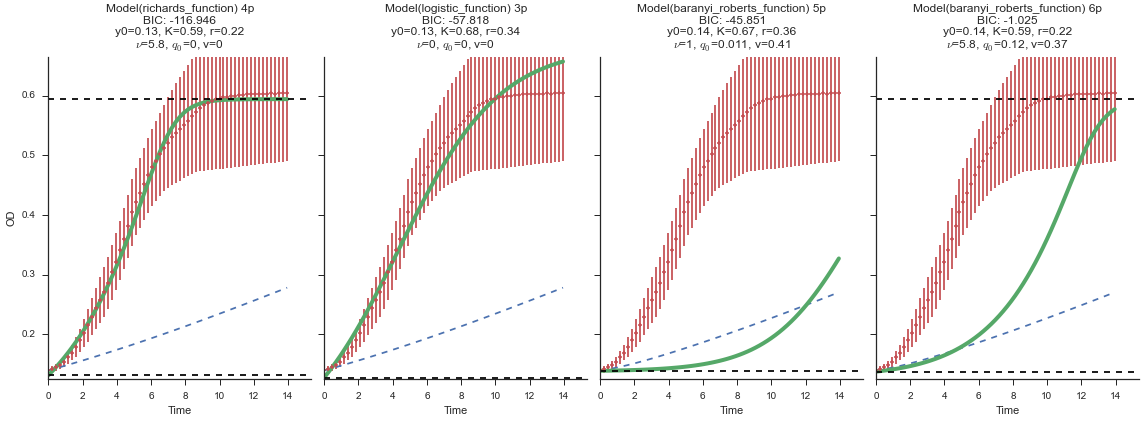

In [32]:
models_RG,fig,ax = curveball.models.fit_model(df_RG)

[[Model]]
    Model(richards_function)
[[Fit Statistics]]
    # function evals   = 161
    # data points      = 61
    # variables        = 4
    chi-square         = 58.977
    reduced chi-square = 1.035
[[Variables]]
    y0:   0.12280193 +/- 0.001222 (1.00%) (init= 0.1382053)
    r:    0.21911232 +/- 0.003761 (1.72%) (init= 0.06662304)
    K:    0.54981232 +/- 0.011710 (2.13%) (init= 0.5621316)
    nu:   7.54333989 +/- 2.196005 (29.11%) (init= 1)



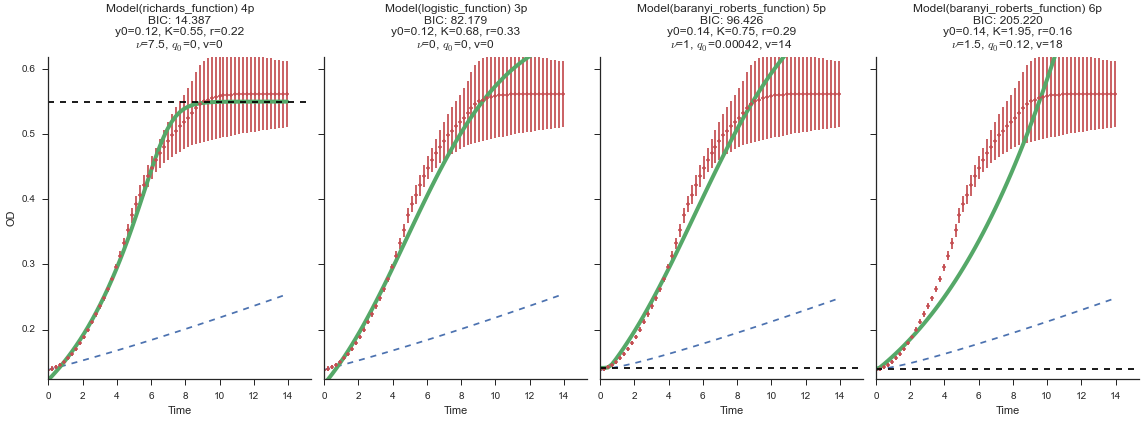

In [38]:
models_RG_clean,fig,ax = curveball.models.fit_model(_df)

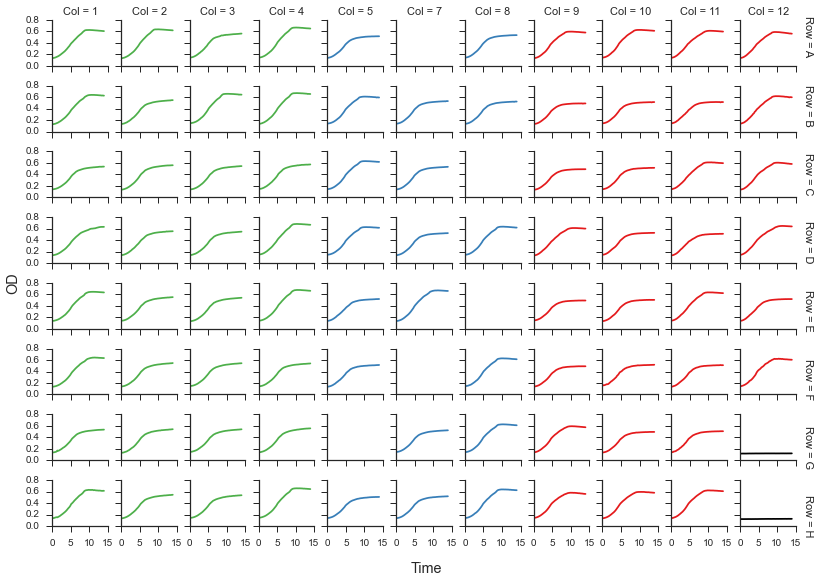

In [51]:
curveball.plots.plot_wells(df[~df.Well.isin(outliers)])

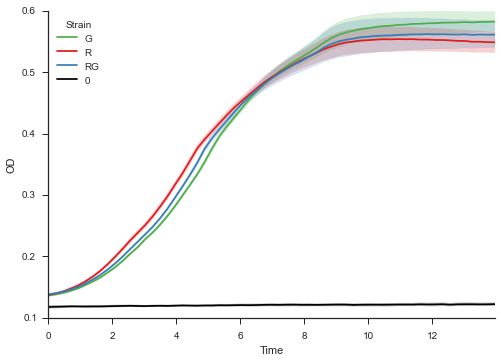

In [53]:
curveball.plots.tsplot(df[~df.Well.isin(outliers)])